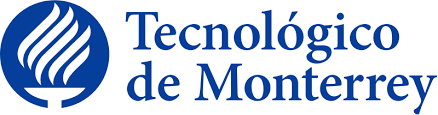

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Actividad en Equipos - Semana 9: Traducciones y clasificación de textos**

###**Equipo 5:**

###**A01748750 - Evelyn Aylin Rendón Medina**
###**A01002111 - Luis Salvador Cruz Najera**
###**A01169213 - Laura Elena Hernández Mata**
###**A01793052 - Juan Carlos Lopez Cruz**
###**A01793054 - Rafael José Mateo Comprés**


#**Actividad en Equipos - Semana 5:**

En la actividad de esta semana trabajarás en equipos mediante el uso de Transformers.

HuggingFace (HF) es una plataforma de una comunidad de IA que promueve las contribuciones de código
abierto, en particular para compartir modelos de aprendizaje profundo, entre ellos los Transformers o modelos basados en el mecanismo de Attention: https://huggingface.co/

La plataforma de HF está muy bien documentada, es de acceso abierto, pero deberás generar una cuenta sin costo para su uso. En ocasiones deberás generar una clave para el uso de algunos modelos, pero es solo para el control del uso de dicha plataforma y no generan algún costo para su uso educativo o de investigación, al menos hasta ahora.

En particular en esta actividad estarás usando varios de los modelos Transformer que hacen tareas diversas, tanto en inglés como en español. El objetivo es que te familiarices con dicha plataforma y experimentes posteriormente con ella para las tareas o problemáticas particulares que te interesen.

# **Actividades:**

###1.- Descarga el archivo amazonbaby5000.csv que se encuentra en Canvas. Este archivo está formado de comentarios en inglés sobre productos para bebé adquiridos en la plataforma de Amazon.###

In [43]:
#!pip install sentencepiece
#!pip install sacremoses
#!pip install pysentimiento

In [44]:
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from datasets import Dataset, load_dataset, DatasetDict

In [45]:
ds = load_dataset("csv", data_files='https://raw.githubusercontent.com/luiscruzn/data/main/amazonbaby5000.csv')
ds = ds.rename_column('rating', 'labels')

ds


Found cached dataset csv (/Users/rmateoc/.cache/huggingface/datasets/csv/default-36695e15bd9d1d63/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'labels'],
        num_rows: 5000
    })
})

In [67]:
#Hacemos una copia de los datos originales, ya que los necesitaremos en el ejercicio 4
ds_copy = ds.copy()

###2.- Realiza una partición de los datos en el porcentaje que consideres adecuado, entrenamiento, validación y prueba.###

In [46]:
#Hacemos partición de entrenamiento, validación y prueba
train_test_valid = ds['train'].train_test_split(test_size=0.3)

# Particionamos validación y prueba en dos grupos (c/u con 50%)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5)

#Ahora hacemos un solo dataset con las tres particiones
ds = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [47]:
ds

DatasetDict({
    train: Dataset({
        features: ['review', 'labels'],
        num_rows: 3500
    })
    test: Dataset({
        features: ['review', 'labels'],
        num_rows: 750
    })
    valid: Dataset({
        features: ['review', 'labels'],
        num_rows: 750
    })
})

### 3.- Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento en inglés y lleva a cabo la predicción de los comentarios en los siguientes casos:###
* ### a. Utilizando un modelo predeterminado de HF de manera directa, es decir, sin ajuste de parámetros del modelo. Indicar el desempeño (accuracy) obtenido.###

In [48]:
import torch
torch.cuda.is_available()

False

In [49]:
def getDevice():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [50]:
device = getDevice()

In [51]:
transf_model = 'LiYuan/amazon-review-sentiment-analysis'

model = AutoModelForSequenceClassification.from_pretrained(transf_model)
tokenizer = AutoTokenizer.from_pretrained(transf_model)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [52]:
sentiment_pipeline = pipeline(
    "sentiment-analysis", 
    model = model,
    tokenizer=tokenizer, 
    device=device)


In [53]:
from evaluate import evaluator
task_evaluator = evaluator("sentiment-analysis")
eval_results = task_evaluator.compute(
    model_or_pipeline = sentiment_pipeline, 
    input_column = 'review',
    label_mapping= {"1 star": 0, '2 stars': 0, '3 stars': 0, '4 stars': 1, '5 stars': 1}, 
    label_column = 'labels', 
    data =  ds['test'])

In [54]:
print(eval_results)

{'accuracy': 0.9333333333333333, 'total_time_in_seconds': 35.67025783401914, 'samples_per_second': 21.025920347699767, 'latency_in_seconds': 0.047560343778692185}


In [55]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

* ### b. Utiliza ahora un ajuste de parámetros (fine-tuning) con el modelo Transformer DistilBERT, para generar un nuevo modelo y clasificación de los comentarios. Es decir, el objetivo es utilizar un modelo Transformer pre-entrenado y adaptarlo (fine-tuning) o ajustarlo a las características de tus datos de entrenamiento. Indicar desempeño (accuracy) obtenido.###

In [56]:
#Función para tokenizar el corpus
def preprocess_function(examples):
   tensor = tokenizer(examples['review'], truncation=True, padding = True, return_tensors="pt")
   tensor.to(device)

   return tensor


In [57]:
#Convertir a dataset desde dataframe de pandas
tokenized_train = ds['train'].map(preprocess_function,batched = True)#Dataset.from_pandas(x_train, split="train").map(preprocess_function, batched=True)
tokenized_val = ds['valid'].map(preprocess_function,batched = True)#Dataset.from_pandas(x_val, split="eval").map(preprocess_function, batched=True)
tokenized_test = ds['test'].map(preprocess_function,batched = True)#Dataset.from_pandas(x_test, split="test").map(preprocess_function, batched=True)

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [58]:
transf_model = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(transf_model)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(transf_model, num_labels = 2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

In [59]:
training_args = TrainingArguments(
output_dir=f'./results',
learning_rate=2e-5,
do_eval=True,
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=2,
weight_decay=0.01,
save_strategy="epoch",
use_mps_device=torch.backends.mps.is_available()) #Usar MPS si está disponible. Aplica para las macs con apple silicon

In [60]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_val,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [61]:
trainer.train()

/Users/rmateoc/.pyenv/versions/3.10.6/envs/nlp-env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/438 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 526.7903, 'train_samples_per_second': 13.288, 'train_steps_per_second': 0.831, 'train_loss': 0.4750943815327126, 'epoch': 2.0}


TrainOutput(global_step=438, training_loss=0.4750943815327126, metrics={'train_runtime': 526.7903, 'train_samples_per_second': 13.288, 'train_steps_per_second': 0.831, 'train_loss': 0.4750943815327126, 'epoch': 2.0})

In [62]:
preds = np.argmax(trainer.predict(tokenized_test).predictions, axis=-1)

  0%|          | 0/47 [00:00<?, ?it/s]

In [63]:
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=tokenized_test['labels'])

{'accuracy': 0.7973333333333333, 'f1': 0.8747940691927513}

* ### c. Compara los resultados e incluye tus comentarios.###
### NOTA: Puedes apoyarte en el siguiente tutorial de la misma comunidad de HF: https://huggingface.co/blog/sentiment-analysis-python ###

###4.- Utiliza el modelo Transformer pre-entrenado para diferentes idiomas llamado Helsinki-NLP de HF, para hacer una traducción del Inglés al Español de los 5000 comentarios. Observa algunos de los comentarios traducidos y comenta qué tan bien consideras dichas traducciones. Por el momento esun simple comentario subjetivo, aunque existen métricas y bases de datos para evaluar el desempeño de un Trasnformer.###

###NOTA: Guarda el archivo de los comentarios traducidos para facilitar su uso en las siguientes preguntas de esta actividad.###

### Existen pocos modelos pre-entrenados con corpus en Español, pero dos de los más conocidos son BETO ( https://github.com/dccuchile/beto ) y MarIA ( https://arxiv.org/abs/2107.07253 ). En particular para análisis de sentimiento se puede utilizar alguno de los modelos derivados de BETO:###

In [70]:
pipe = pipeline(
    "translation", 
    model="Helsinki-NLP/opus-mt-en-es", 
    tokenizer= 'Helsinki-NLP/opus-mt-en-es',
    truncation = True, 
    device=device, 
    batch_size = 16, 
    max_length = 512)

#Como demostración, se traducen 20 comentarios para que al correrlo no tarde mucho el modelo. 
# Sin embargo, el trabajo de la traducción ya se hizo y se carga el archivo de los 5,000 comentarios más abajo
translations = pipe(ds_copy['train']['review'][:20]) 

/Users/rmateoc/.pyenv/versions/3.10.6/envs/nlp-env/lib/python3.10/site-packages/transformers/generation/utils.py:723: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  input_ids = input_ids.repeat_interleave(expand_size, dim=0)
/Users/rmateoc/.pyenv/versions/3.10.6/envs/nlp-env/lib/python3.10/site-packages/transformers/generation/beam_search.py:357: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  sent_lengths_max = sent_lengths.max().item() + 1


In [71]:
translations[:5]

[{'translation_text': 'Tengo esto para él alrededor de 4 meses, en el momento en que no le importaba demasiado. Ahora que su coordinación de manos es mejor que le encanta!!!!'},
 {'translation_text': 'Este sonajero es hermoso. Es muy suave y tiene un sonido sutil agradable. Compré esto para mi casi 3 años de edad, que a pesar de la coloración natural, rastreará el sonajero cuando se sacude. Para mi sorpresa, mi 20 meses de edad también encuentra esto interesante y ha estado masticando en él desde que lo encontró por primera vez. También me sorprendió ver que no hay absolutamente ninguna marca de dientes! Tenemos el arce y estamos ordenando la cereza.'},
 {'translation_text': 'Estas cerraduras son horribles. Estoy tan contento de que no soy el único que piensa así porque son tan difíciles de usar. Tuve que luchar para que se abran para empezar, y me tomó casi 10 minutos para luchar fuera de mi gabinete después de ponerlo en. Tal pérdida de dinero.'},
 {'translation_text': 'Compré esta c

In [79]:
translation_list = {'reviews': [translation['translation_text'] for translation in translations], 'labels': ds_copy['train']['labels'][:20]}
translation_list

{'reviews': ['Tengo esto para él alrededor de 4 meses, en el momento en que no le importaba demasiado. Ahora que su coordinación de manos es mejor que le encanta!!!!',
  'Este sonajero es hermoso. Es muy suave y tiene un sonido sutil agradable. Compré esto para mi casi 3 años de edad, que a pesar de la coloración natural, rastreará el sonajero cuando se sacude. Para mi sorpresa, mi 20 meses de edad también encuentra esto interesante y ha estado masticando en él desde que lo encontró por primera vez. También me sorprendió ver que no hay absolutamente ninguna marca de dientes! Tenemos el arce y estamos ordenando la cereza.',
  'Estas cerraduras son horribles. Estoy tan contento de que no soy el único que piensa así porque son tan difíciles de usar. Tuve que luchar para que se abran para empezar, y me tomó casi 10 minutos para luchar fuera de mi gabinete después de ponerlo en. Tal pérdida de dinero.',
  'Compré esta cosa para mi nuevo sobrino y estoy satisfecho, sus padres me dijeron que 

In [80]:
#llevamos los comentarios traducidos a un dataframe de pandas
ds_translated = Dataset.from_dict(translation_list)#pd.DataFrame(translation_list)
ds_translated.to_pandas().head()

,reviews,labels
0,"Tengo esto para él alrededor de 4 meses, en el...",1
1,Este sonajero es hermoso. Es muy suave y tiene...,1
2,Estas cerraduras son horribles. Estoy tan cont...,0
3,Compré esta cosa para mi nuevo sobrino y estoy...,1
4,"Tengo una UPPA VISTA, las barras de la manija ...",0


In [81]:
#Guardamos las traducciones en un csv. Utilizanmos amazonbaby10 como nombre del archivo para no sobrescribir el que tiene los 5,000 comentarios.
ds_translated.to_csv('./amazonbaby10-es.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

9744

In [82]:
#Leemos el de los 5,000 comentarios que estaremos utilizando
ds_translated = load_dataset('csv', data_files='./amazonbaby5000-es.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/rmateoc/.cache/huggingface/datasets/csv/default-a116737b5253ce0f/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
ds_translated['train'].to_pandas().head()

,reviews,labels
0,Creo que es más caro que la farmacia que sólo ...,0
1,"Cuando vi esto en Amazon, lo puse en mi lista ...",1
2,Realmente nos gustan estos valances. Tienen pe...,1
3,No hay luz que emita de la luz nocturna. Lo pi...,0
4,Realmente esperaba que esto fuera un dispensad...,0


###5.- Utiliza el modelo Transformer “pysentimiento”, basado en BETO y este a su vez basado en BERT, para llevar a cabo un análisis de sentimiento (sentiment analysis) y hacer la predicción de los comentarios traducidos al español. Incluye tus comentarios del resultado obtenido.###

In [23]:
pipe = pipeline("sentiment-analysis", model="Helsinki-NLP/opus-mt-en-es")

The model 'MarianMTModel' is not supported for sentiment-analysis. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GPT2ForSequenceClassification', 'GPT2ForSequenceClassification', 'GPTBigCodeForSequenceClassification', 'GPTNeoForSequence

### 6.- Resume los resultados obtenidos en esta actividad de manera tabular e incluye tus comentarios finales.###

###NOTA: A partir de esta actividad, no dudes en experimentar con otros modelos Transformer pre-entrenados tanto para traducción al español, como para análisis de sentimiento.###

## **Referencias:**

* KeepCoding. (s.f.). ¿Qué es el topic modeling?. https://keepcoding.io/blog/que-es-el-topic-modeling/#:~:text=El%20topic%20modeling%20es%20un,los%20que%20se%20est%C3%A1%20hablando.

* Amat,J.(2016). Análisis discriminante lineal (LDA) y análisis discriminante cuadrático (QDA). cienciadedatos.net. https://www.cienciadedatos.net/documentos/28_linear_discriminant_analysis_lda_y_quadratic_discriminant_analysis_qda

* BIMsoluciones. (2021, July 21). Que es Indexación semántica latente o LSI. https://bimsoluciones.com/indexacion-semantica/

* Vajjala, S., Majumder, B., Gupta, A., y Surana, H. (2020). Practical Natural Language Processing: A Comprehensive Guide to Building Real-World NLP Systems. O'Reilly

* Falcón Morales, L. E. (2023). Modelado de Temas: LSI [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM.

* Falcón Morales, L. E. (2023). Modelado_de_Temas_LDA [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM.